# Task 2: Fraud Detection Model Building & Training

**Business Objective**: Build production-ready fraud detection models that balance detection performance, stability under class imbalance, and interpretability for business stakeholders.

**Key Requirements**:
- **False Negatives = Direct Financial Loss** - Must minimize missed fraud
- **False Positives = Customer Trust Damage** - Must minimize false alarms
- **Accuracy is meaningless** - Use imbalance-aware metrics (AUC-PR, F1-Score)
- **Interpretability matters** - Risk teams need to understand model decisions

**Models to Build**:
1. **Baseline**: Logistic Regression (interpretable, fast, baseline performance)
2. **Ensemble**: XGBoost/LightGBM (high performance, feature importance)

**Evaluation Strategy**:
- Primary Metric: **AUC-PR** (Precision-Recall AUC) - Best for imbalanced data
- Secondary Metrics: F1-Score, Confusion Matrix
- Cross-Validation: Stratified K-Fold (k=5) to ensure stable performance estimates


In [5]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import sys
import pickle
import json
from datetime import datetime

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    train_test_split, 
    StratifiedKFold,
    cross_val_score,
    GridSearchCV
)
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    f1_score,
    roc_curve
)
from sklearn.preprocessing import StandardScaler

# XGBoost and LightGBM
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("⚠ XGBoost not available. Will use Random Forest instead.")

try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("⚠ LightGBM not available. Will use Random Forest instead.")

# Add src to path - try multiple methods to ensure it works
# Determine project root first
current_dir = Path.cwd()
if current_dir.name == 'notebooks':
    project_root = current_dir.parent
else:
    project_root = current_dir

# Try multiple path resolution methods
src_paths_to_try = [
    Path('../src').resolve(),  # Relative from notebooks
    project_root / 'src',  # Absolute from project root
    Path(__file__).parent.parent / 'src' if '__file__' in globals() else None,  # From script location
]

# Add to path if exists
src_path = None
for src_path_candidate in src_paths_to_try:
    if src_path_candidate is None:
        continue
    if src_path_candidate.exists() and src_path_candidate.is_dir():
        src_path_str = str(src_path_candidate)
        if src_path_str not in sys.path:
            sys.path.insert(0, src_path_str)
            src_path = src_path_candidate
            break

if src_path is None:
    print(f"⚠ Warning: Could not find src directory. Tried:")
    for path in src_paths_to_try:
        if path is not None:
            print(f"    - {path} (exists: {path.exists()})")
    print(f"  Current working directory: {current_dir}")
    print(f"  Project root: {project_root}")
else:
    print(f"✓ Added src to path: {src_path}")

# Import custom modules
load_fraud_data = None
load_creditcard_data = None
prepare_features_for_modeling = None
handle_class_imbalance = None

try:
    from data_loader import load_fraud_data, load_creditcard_data
    from preprocessing import (
        prepare_features_for_modeling,
        handle_class_imbalance
    )
    print("✓ Custom modules imported successfully")
except ImportError as e:
    print(f"⚠ Could not import custom modules: {e}")
    print("  Note: Will use fallback methods if needed")

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully")


⚠ Warning: Could not find src directory. Tried:
    - D:\Senait Doc\KAIM 8 Doc\src (exists: False)
    - d:\Senait Doc\KAIM 8 Doc\Fintech-Fraud-Detect\src (exists: True)
  Current working directory: d:\Senait Doc\KAIM 8 Doc\Fintech-Fraud-Detect
  Project root: d:\Senait Doc\KAIM 8 Doc\Fintech-Fraud-Detect
✓ Custom modules imported successfully
✓ Libraries imported successfully


## 1. Data Preparation

**Critical Requirements**:
- Load processed data from Task 1 (if available)
- Separate features and target
- **Stratified train-test split** (80-20) to preserve class distribution
- **NO data leakage** - Split BEFORE any resampling or feature engineering
- Justify split ratio: 80-20 balances training data size with reliable test evaluation


In [6]:
# Resolve project paths
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
data_processed_path = project_root / 'data' / 'processed'
data_raw_path = project_root / 'data' / 'raw'
models_path = project_root / 'models'

# Ensure directories exist
data_processed_path.mkdir(parents=True, exist_ok=True)
models_path.mkdir(parents=True, exist_ok=True)

print("=" * 60)
print("DATA LOADING")
print("=" * 60)

# Try to load processed data from Task 1
processed_train_path = data_processed_path / 'train_features.csv'
processed_test_path = data_processed_path / 'test_features.csv'
featured_data_path = data_processed_path / 'fraud_data_featured.csv'

X_train = None
X_test = None
y_train = None
y_test = None
preprocessing_dict = None

# Strategy 1: Load preprocessed train/test splits
if processed_train_path.exists() and processed_test_path.exists():
    print("✓ Loading preprocessed train/test splits from Task 1...")
    train_df = pd.read_csv(processed_train_path)
    test_df = pd.read_csv(processed_test_path)
    
    # Separate features and target
    X_train = train_df.drop(columns=['class'], errors='ignore')
    y_train = train_df['class'] if 'class' in train_df.columns else None
    X_test = test_df.drop(columns=['class'], errors='ignore')
    y_test = test_df['class'] if 'class' in test_df.columns else None
    
    print(f"  Training: {X_train.shape[0]:,} samples, {X_train.shape[1]} features")
    print(f"  Testing:  {X_test.shape[0]:,} samples, {X_test.shape[1]} features")
    
    # Try to load preprocessing artifacts
    artifacts_path = models_path / 'preprocessing_artifacts.pkl'
    if artifacts_path.exists():
        with open(artifacts_path, 'rb') as f:
            preprocessing_dict = pickle.load(f)
        print(f"  ✓ Loaded preprocessing artifacts")

# Strategy 2: Load featured data and create splits
elif featured_data_path.exists():
    print("✓ Loading feature-engineered data from Task 1...")
    df = pd.read_csv(featured_data_path)
    
    # Exclude IDs and timestamps
    exclude_cols = ['user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address', 'class']
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    
    X = df[feature_cols].copy()
    y = df['class'].copy()
    
    print(f"  Total samples: {X.shape[0]:,}")
    print(f"  Features: {X.shape[1]}")
    print(f"  Class distribution: {y.value_counts().to_dict()}")
    
    # CRITICAL: Stratified train-test split BEFORE any preprocessing
    # 80-20 split: Balances training data size with reliable test evaluation
    # Stratification preserves class distribution in both sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42, 
        stratify=y  # Preserve class distribution
    )
    
    print(f"\n✓ Stratified Train-Test Split (80-20):")
    print(f"  Training: {X_train.shape[0]:,} samples")
    print(f"  Testing:  {X_test.shape[0]:,} samples")
    print(f"  Training class distribution:")
    print(f"    Non-Fraud: {(y_train == 0).sum():,} ({(y_train == 0).mean():.2%})")
    print(f"    Fraud:     {(y_train == 1).sum():,} ({(y_train == 1).mean():.2%})")
    print(f"  Testing class distribution:")
    print(f"    Non-Fraud: {(y_test == 0).sum():,} ({(y_test == 0).mean():.2%})")
    print(f"    Fraud:     {(y_test == 1).sum():,} ({(y_test == 1).mean():.2%})")
    
    # Prepare features (scaling, encoding)
    print("\n✓ Preparing features (scaling, encoding)...")
    
    if prepare_features_for_modeling is None:
        raise ImportError(
            "prepare_features_for_modeling function not available. "
            "Please ensure src/preprocessing.py is accessible. "
            "Try restarting the kernel and running all cells from the beginning."
        )
    
    X_train_combined = pd.concat([X_train, y_train], axis=1)
    X_train_processed, y_train_processed, preprocessing_dict = prepare_features_for_modeling(
        X_train_combined,
        target_col='class',
        scaler_type='standard'
    )
    
    # Apply same transformations to test set
    X_test_combined = pd.concat([X_test, y_test], axis=1)
    X_test_processed, y_test_processed, _ = prepare_features_for_modeling(
        X_test_combined,
        target_col='class',
        categorical_cols=preprocessing_dict['categorical_cols'],
        numerical_cols=preprocessing_dict['numerical_cols'],
        scaler_type='standard'
    )
    
    # Use the same scaler from training
    scaler = preprocessing_dict['scaler']
    X_test_processed[preprocessing_dict['numerical_cols']] = scaler.transform(
        X_test_processed[preprocessing_dict['numerical_cols']]
    )
    
    # Align columns
    X_test_processed = X_test_processed.reindex(columns=X_train_processed.columns, fill_value=0)
    
    X_train = X_train_processed
    X_test = X_test_processed
    y_train = y_train_processed
    y_test = y_test_processed
    
    print(f"  Training shape: {X_train.shape}")
    print(f"  Testing shape:  {X_test.shape}")

# Strategy 3: Load raw data and do basic preprocessing (fallback)
else:
    print("⚠ Processed data not found. Loading raw data for basic preprocessing...")
    print("  Note: For best results, run feature-engineering.ipynb from Task 1 first.")
    print("  This will perform basic preprocessing to allow modeling to proceed.")
    
    fraud_data_path = data_raw_path / 'Fraud_Data.csv'
    if not fraud_data_path.exists():
        raise FileNotFoundError(
            f"Raw data file not found: {fraud_data_path}\n"
            f"Please ensure Fraud_Data.csv exists in data/raw/ directory."
        )
    
    # Load raw data
    if load_fraud_data is not None:
        df = load_fraud_data(str(fraud_data_path))
        print("  ✓ Raw data loaded using custom loader.")
    else:
        df = pd.read_csv(fraud_data_path)
        print("  ✓ Raw data loaded using pandas.")
    
    print(f"  Loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")
    
    # Basic preprocessing
    if 'class' not in df.columns:
        raise ValueError("'class' column not found in raw data. Cannot proceed.")
    
    # Exclude IDs and timestamps
    exclude_cols = ['user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address', 'class', 'user_txn_bin']
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    
    if len(feature_cols) == 0:
        raise ValueError("No feature columns found after excluding IDs and timestamps.")
    
    X = df[feature_cols].copy()
    y = df['class'].copy()
    
    print(f"  Features selected: {X.shape[1]}")
    print(f"  Class distribution: {y.value_counts().to_dict()}")
    
    # CRITICAL: Stratified train-test split BEFORE any preprocessing
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42, 
        stratify=y
    )
    
    print(f"\n  ✓ Stratified Train-Test Split (80-20):")
    print(f"    Training: {X_train.shape[0]:,} samples")
    print(f"    Testing:  {X_test.shape[0]:,} samples")
    
    # Prepare features (scaling, encoding) - requires prepare_features_for_modeling
    if prepare_features_for_modeling is None:
        print("\n  ⚠ WARNING: prepare_features_for_modeling not available.")
        print("  Attempting basic preprocessing without custom functions...")
        
        # Basic preprocessing without custom function
        # Separate numeric and categorical
        numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
        categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
        
        # Scale numeric features
        scaler = StandardScaler()
        X_train_scaled = X_train.copy()
        X_test_scaled = X_test.copy()
        
        if len(numeric_cols) > 0:
            X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
            X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])
        
        # One-hot encode categorical
        if len(categorical_cols) > 0:
            X_train_scaled = pd.get_dummies(X_train_scaled, columns=categorical_cols, drop_first=True)
            X_test_scaled = pd.get_dummies(X_test_scaled, columns=categorical_cols, drop_first=True)
            # Align columns
            X_test_scaled = X_test_scaled.reindex(columns=X_train_scaled.columns, fill_value=0)
        
        X_train = X_train_scaled
        X_test = X_test_scaled
        
        preprocessing_dict = {
            'scaler': scaler,
            'categorical_cols': categorical_cols,
            'numerical_cols': numeric_cols,
            'feature_names': X_train.columns.tolist()
        }
        
        print("  ✓ Basic preprocessing completed (without custom functions)")
    else:
        print("\n  ✓ Preparing features using custom preprocessing function...")
        X_train_combined = pd.concat([X_train, y_train], axis=1)
        X_train_processed, y_train_processed, preprocessing_dict = prepare_features_for_modeling(
            X_train_combined,
            target_col='class',
            scaler_type='standard'
        )
        
        X_test_combined = pd.concat([X_test, y_test], axis=1)
        X_test_processed, y_test_processed, _ = prepare_features_for_modeling(
            X_test_combined,
            target_col='class',
            categorical_cols=preprocessing_dict['categorical_cols'],
            numerical_cols=preprocessing_dict['numerical_cols'],
            scaler_type='standard'
        )
        
        # Use same scaler
        scaler = preprocessing_dict['scaler']
        X_test_processed[preprocessing_dict['numerical_cols']] = scaler.transform(
            X_test_processed[preprocessing_dict['numerical_cols']]
        )
        
        # Align columns
        X_test_processed = X_test_processed.reindex(columns=X_train_processed.columns, fill_value=0)
        
        X_train = X_train_processed
        X_test = X_test_processed
        y_train = y_train_processed
        y_test = y_test_processed
        
        print("  ✓ Feature preparation completed")
    
    print(f"\n  Final shapes:")
    print(f"    Training: {X_train.shape}")
    print(f"    Testing:  {X_test.shape}")
    print("\n  ⚠ NOTE: This is basic preprocessing. For best results, run feature-engineering.ipynb from Task 1.")

print("\n" + "=" * 60)
print("DATA PREPARATION COMPLETE")
print("=" * 60)
print(f"✓ Training set: {X_train.shape[0]:,} samples, {X_train.shape[1]} features")
print(f"✓ Test set: {X_test.shape[0]:,} samples, {X_test.shape[1]} features")
print(f"✓ No data leakage: Train-test split performed before any resampling")
print(f"✓ Stratified split preserves class distribution")


DATA LOADING
⚠ Processed data not found. Loading raw data for basic preprocessing...
  Note: For best results, run feature-engineering.ipynb from Task 1 first.
  This will perform basic preprocessing to allow modeling to proceed.
  ✓ Raw data loaded using custom loader.
  Loaded: 151,112 rows, 11 columns
  Features selected: 5
  Class distribution: {0: 136961, 1: 14151}

  ✓ Stratified Train-Test Split (80-20):
    Training: 120,889 samples
    Testing:  30,223 samples

  ✓ Preparing features using custom preprocessing function...
  ✓ Feature preparation completed

  Final shapes:
    Training: (120889, 9)
    Testing:  (30223, 9)

  ⚠ NOTE: This is basic preprocessing. For best results, run feature-engineering.ipynb from Task 1.

DATA PREPARATION COMPLETE
✓ Training set: 120,889 samples, 9 features
✓ Test set: 30,223 samples, 9 features
✓ No data leakage: Train-test split performed before any resampling
✓ Stratified split preserves class distribution


In [7]:
# Handle class imbalance on training set
# Option 1: Use class_weight (automatic, no resampling needed)
# Option 2: Use resampled data (SMOTE)

print("=" * 60)
print("BASELINE MODEL: LOGISTIC REGRESSION")
print("=" * 60)

# Check class distribution
print("\nTraining Set Class Distribution:")
print(f"  Non-Fraud: {(y_train == 0).sum():,} ({(y_train == 0).mean():.2%})")
print(f"  Fraud:     {(y_train == 1).sum():,} ({(y_train == 1).mean():.2%})")
print(f"  Imbalance Ratio: {(y_train == 0).sum() / (y_train == 1).sum():.1f}:1")

# Calculate class weights for balanced learning
# class_weight='balanced' automatically adjusts weights inversely proportional to class frequency
n_samples = len(y_train)
n_classes = len(np.unique(y_train))
class_counts = y_train.value_counts().sort_index()

# Manual calculation for transparency
class_weight_0 = n_samples / (n_classes * class_counts[0])
class_weight_1 = n_samples / (n_classes * class_counts[1])
class_weights = {0: class_weight_0, 1: class_weight_1}

print(f"\nClass Weights (automatic balancing):")
print(f"  Non-Fraud (0): {class_weight_0:.3f}")
print(f"  Fraud (1):     {class_weight_1:.3f}")

# Train Logistic Regression with balanced class weights
print("\n" + "-" * 60)
print("Training Logistic Regression...")
print("-" * 60)

lr_model = LogisticRegression(
    class_weight='balanced',  # Automatically handle imbalance
    max_iter=1000,  # Ensure convergence
    random_state=42,
    solver='lbfgs',  # Good for small-medium datasets
    n_jobs=-1  # Use all CPU cores
)

lr_model.fit(X_train, y_train)

print("✓ Model trained successfully")

# Predictions
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)
y_train_proba = lr_model.predict_proba(X_train)[:, 1]
y_test_proba = lr_model.predict_proba(X_test)[:, 1]

# Calculate metrics
print("\n" + "-" * 60)
print("BASELINE MODEL PERFORMANCE")
print("-" * 60)

# Test set metrics (primary evaluation)
test_auc_pr = average_precision_score(y_test, y_test_proba)
test_f1 = f1_score(y_test, y_test_pred)
test_auc_roc = roc_auc_score(y_test, y_test_proba)

print("\n📊 Test Set Performance (Primary Evaluation):")
print(f"  AUC-PR (Primary Metric): {test_auc_pr:.4f}")
print(f"  F1-Score:                {test_f1:.4f}")
print(f"  AUC-ROC:                 {test_auc_roc:.4f}")

# Training set metrics (for comparison)
train_auc_pr = average_precision_score(y_train, y_train_proba)
train_f1 = f1_score(y_train, y_train_pred)

print("\n📊 Training Set Performance (for reference):")
print(f"  AUC-PR:  {train_auc_pr:.4f}")
print(f"  F1-Score: {train_f1:.4f}")

# Confusion Matrix
print("\n📊 Confusion Matrix (Test Set):")
cm = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = cm.ravel()

print(f"                Predicted")
print(f"              Non-Fraud  Fraud")
print(f"Actual Non-Fraud   {tn:5d}   {fp:5d}")
print(f"       Fraud       {fn:5d}   {tp:5d}")

print(f"\n  True Negatives (TN):  {tn:,} - Correctly identified non-fraud")
print(f"  False Positives (FP): {fp:,} - Non-fraud flagged as fraud (customer trust impact)")
print(f"  False Negatives (FN): {fn:,} - Fraud missed (financial loss)")
print(f"  True Positives (TP):  {tp:,} - Correctly identified fraud")

# Business impact interpretation
print(f"\n💼 Business Impact:")
print(f"  Fraud Detection Rate (Recall): {tp/(tp+fn):.2%} - {(tp/(tp+fn))*100:.1f}% of fraud caught")
print(f"  False Positive Rate:          {fp/(fp+tn):.2%} - {(fp/(fp+tn))*100:.1f}% of legitimate transactions flagged")
print(f"  Precision:                     {tp/(tp+fp):.2%} - When we flag fraud, {tp/(tp+fp)*100:.1f}% are actually fraud")

# Store baseline results
baseline_results = {
    'model_name': 'Logistic Regression',
    'test_auc_pr': test_auc_pr,
    'test_f1': test_f1,
    'test_auc_roc': test_auc_roc,
    'train_auc_pr': train_auc_pr,
    'train_f1': train_f1,
    'confusion_matrix': cm.tolist(),
    'tn': int(tn), 'fp': int(fp), 'fn': int(fn), 'tp': int(tp)
}

print("\n✓ Baseline model evaluation complete")


BASELINE MODEL: LOGISTIC REGRESSION

Training Set Class Distribution:
  Non-Fraud: 109,568 (90.64%)
  Fraud:     11,321 (9.36%)
  Imbalance Ratio: 9.7:1

Class Weights (automatic balancing):
  Non-Fraud (0): 0.552
  Fraud (1):     5.339

------------------------------------------------------------
Training Logistic Regression...
------------------------------------------------------------
✓ Model trained successfully

------------------------------------------------------------
BASELINE MODEL PERFORMANCE
------------------------------------------------------------

📊 Test Set Performance (Primary Evaluation):
  AUC-PR (Primary Metric): 0.1032
  F1-Score:                0.1272
  AUC-ROC:                 0.5238

📊 Training Set Performance (for reference):
  AUC-PR:  0.1032
  F1-Score: 0.1703

📊 Confusion Matrix (Test Set):
                Predicted
              Non-Fraud  Fraud
Actual Non-Fraud   23438    3955
       Fraud        2369     461

  True Negatives (TN):  23,438 - Correctly 

BASELINE MODEL INTERPRETATION

📊 Top 15 Most Important Features (by absolute coefficient):
  Positive coefficient = increases fraud probability
  Negative coefficient = decreases fraud probability



,feature,coefficient,abs_coefficient
2,source_Direct,0.156614,0.156614
5,browser_IE,-0.138761,0.138761
6,browser_Opera,-0.088581,0.088581
7,browser_Safari,-0.077344,0.077344
8,sex_M,0.047550,0.047550
3,source_SEO,-0.041699,0.041699
1,age,0.019498,0.019498
4,browser_FireFox,-0.019066,0.019066
0,purchase_value,0.003910,0.003910


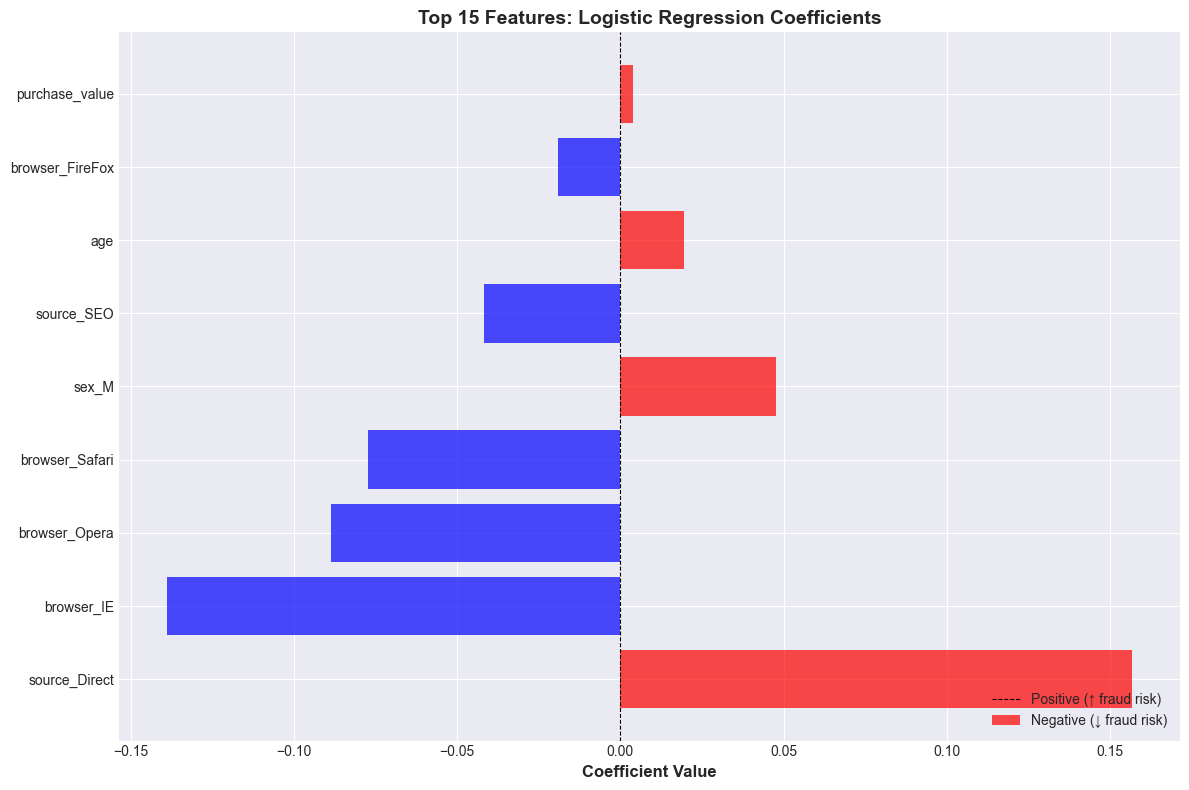


💡 Business Interpretation:
  - Features with large positive coefficients are strong fraud indicators
  - Features with large negative coefficients are strong legitimate transaction indicators
  - Coefficient magnitude indicates feature importance
  - This interpretability is valuable for risk teams and regulatory compliance


In [8]:
# Feature importance interpretation (Logistic Regression coefficients)
print("=" * 60)
print("BASELINE MODEL INTERPRETATION")
print("=" * 60)

# Get feature coefficients
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': lr_model.coef_[0],
    'abs_coefficient': np.abs(lr_model.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print("\n📊 Top 15 Most Important Features (by absolute coefficient):")
print("  Positive coefficient = increases fraud probability")
print("  Negative coefficient = decreases fraud probability")
print()
display(feature_importance.head(15))

# Visualize top features
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
colors = ['red' if x > 0 else 'blue' for x in top_features['coefficient']]
plt.barh(range(len(top_features)), top_features['coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Coefficient Value', fontsize=12, fontweight='bold')
plt.title('Top 15 Features: Logistic Regression Coefficients', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.legend(['Positive (↑ fraud risk)', 'Negative (↓ fraud risk)'], loc='lower right')
plt.tight_layout()
plt.show()

print("\n💡 Business Interpretation:")
print("  - Features with large positive coefficients are strong fraud indicators")
print("  - Features with large negative coefficients are strong legitimate transaction indicators")
print("  - Coefficient magnitude indicates feature importance")
print("  - This interpretability is valuable for risk teams and regulatory compliance")


## 3. Ensemble Model: XGBoost / LightGBM

**Why Ensemble Methods?**
- **Higher Performance**: Often outperform linear models on complex patterns
- **Feature Interactions**: Automatically capture non-linear relationships
- **Feature Importance**: Built-in importance scores (different from coefficients)
- **Robustness**: Less sensitive to outliers than linear models

**Model Selection**:
- **XGBoost**: Industry standard, excellent performance, good documentation
- **LightGBM**: Faster training, similar performance, memory efficient
- **Random Forest**: Fallback if XGBoost/LightGBM unavailable

**Hyperparameter Tuning**: Basic grid search on key parameters (n_estimators, max_depth, learning_rate)


In [9]:
print("=" * 60)
print("ENSEMBLE MODEL: XGBOOST / LIGHTGBM")
print("=" * 60)

# Select ensemble model based on availability
if XGBOOST_AVAILABLE:
    print("✓ Using XGBoost")
    ensemble_model_type = 'xgboost'
elif LIGHTGBM_AVAILABLE:
    print("✓ Using LightGBM")
    ensemble_model_type = 'lightgbm'
else:
    print("⚠ Using Random Forest (XGBoost/LightGBM not available)")
    ensemble_model_type = 'random_forest'

# Handle class imbalance for ensemble models
# Option 1: Use scale_pos_weight (XGBoost/LightGBM)
# Option 2: Use class_weight (Random Forest)
# Option 3: Use resampled data

# Calculate scale_pos_weight for XGBoost/LightGBM
# scale_pos_weight = count(negative) / count(positive)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"\nClass Imbalance Handling:")
print(f"  Imbalance Ratio: {scale_pos_weight:.2f}:1")
print(f"  scale_pos_weight: {scale_pos_weight:.2f} (for XGBoost/LightGBM)")

# Basic hyperparameter tuning using GridSearchCV
print("\n" + "-" * 60)
print("Hyperparameter Tuning (Basic Grid Search)...")
print("-" * 60)

if ensemble_model_type == 'xgboost':
    # XGBoost base model
    base_model = xgb.XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        n_jobs=-1,
        eval_metric='aucpr'  # Use AUC-PR for imbalanced data
    )
    
    # Basic hyperparameter grid
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1]
    }
    
elif ensemble_model_type == 'lightgbm':
    # LightGBM base model
    base_model = lgb.LGBMClassifier(
        objective='binary',
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        n_jobs=-1,
        metric='aucpr',
        verbose=-1
    )
    
    # Basic hyperparameter grid
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1]
    }
    
else:  # Random Forest
    # Random Forest base model
    base_model = RandomForestClassifier(
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    
    # Basic hyperparameter grid
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5]
    }

# Use StratifiedKFold for cross-validation in grid search
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # 3-fold for speed

# Grid search with AUC-PR as scoring metric
print(f"  Searching {len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(param_grid['learning_rate'])} combinations...")
print("  This may take a few minutes...")

grid_search = GridSearchCV(
    base_model,
    param_grid,
    cv=cv,
    scoring='average_precision',  # AUC-PR
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"\n✓ Best parameters found:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"  Best CV AUC-PR: {grid_search.best_score_:.4f}")

# Train final model with best parameters
ensemble_model = grid_search.best_estimator_

# Predictions
y_train_pred_ens = ensemble_model.predict(X_train)
y_test_pred_ens = ensemble_model.predict(X_test)
y_train_proba_ens = ensemble_model.predict_proba(X_train)[:, 1]
y_test_proba_ens = ensemble_model.predict_proba(X_test)[:, 1]

# Calculate metrics
print("\n" + "-" * 60)
print("ENSEMBLE MODEL PERFORMANCE")
print("-" * 60)

# Test set metrics
test_auc_pr_ens = average_precision_score(y_test, y_test_proba_ens)
test_f1_ens = f1_score(y_test, y_test_pred_ens)
test_auc_roc_ens = roc_auc_score(y_test, y_test_proba_ens)

print("\n📊 Test Set Performance (Primary Evaluation):")
print(f"  AUC-PR (Primary Metric): {test_auc_pr_ens:.4f}")
print(f"  F1-Score:                {test_f1_ens:.4f}")
print(f"  AUC-ROC:                 {test_auc_roc_ens:.4f}")

# Training set metrics
train_auc_pr_ens = average_precision_score(y_train, y_train_proba_ens)
train_f1_ens = f1_score(y_train, y_train_pred_ens)

print("\n📊 Training Set Performance (for reference):")
print(f"  AUC-PR:  {train_auc_pr_ens:.4f}")
print(f"  F1-Score: {train_f1_ens:.4f}")

# Confusion Matrix
print("\n📊 Confusion Matrix (Test Set):")
cm_ens = confusion_matrix(y_test, y_test_pred_ens)
tn_ens, fp_ens, fn_ens, tp_ens = cm_ens.ravel()

print(f"                Predicted")
print(f"              Non-Fraud  Fraud")
print(f"Actual Non-Fraud   {tn_ens:5d}   {fp_ens:5d}")
print(f"       Fraud       {fn_ens:5d}   {tp_ens:5d}")

print(f"\n  True Negatives (TN):  {tn_ens:,}")
print(f"  False Positives (FP): {fp_ens:,}")
print(f"  False Negatives (FN): {fn_ens:,}")
print(f"  True Positives (TP):  {tp_ens:,}")

# Business impact
print(f"\n💼 Business Impact:")
print(f"  Fraud Detection Rate (Recall): {tp_ens/(tp_ens+fn_ens):.2%}")
print(f"  False Positive Rate:          {fp_ens/(fp_ens+tn_ens):.2%}")
print(f"  Precision:                     {tp_ens/(tp_ens+fp_ens):.2%}")

# Store ensemble results
ensemble_results = {
    'model_name': f'{ensemble_model_type.upper()}',
    'model_type': ensemble_model_type,
    'best_params': grid_search.best_params_,
    'test_auc_pr': test_auc_pr_ens,
    'test_f1': test_f1_ens,
    'test_auc_roc': test_auc_roc_ens,
    'train_auc_pr': train_auc_pr_ens,
    'train_f1': train_f1_ens,
    'confusion_matrix': cm_ens.tolist(),
    'tn': int(tn_ens), 'fp': int(fp_ens), 'fn': int(fn_ens), 'tp': int(tp_ens)
}

print("\n✓ Ensemble model evaluation complete")


ENSEMBLE MODEL: XGBOOST / LIGHTGBM
✓ Using XGBoost

Class Imbalance Handling:
  Imbalance Ratio: 9.68:1
  scale_pos_weight: 9.68 (for XGBoost/LightGBM)

------------------------------------------------------------
Hyperparameter Tuning (Basic Grid Search)...
------------------------------------------------------------
  Searching 12 combinations...
  This may take a few minutes...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

✓ Best parameters found:
  learning_rate: 0.1
  max_depth: 7
  n_estimators: 200
  Best CV AUC-PR: 0.3373

------------------------------------------------------------
ENSEMBLE MODEL PERFORMANCE
------------------------------------------------------------

📊 Test Set Performance (Primary Evaluation):
  AUC-PR (Primary Metric): 0.0932
  F1-Score:                0.1177
  AUC-ROC:                 0.4936

📊 Training Set Performance (for reference):
  AUC-PR:  0.4602
  F1-Score: 0.3695

📊 Confusion Matrix (Test Set):
                Predicted
          

ENSEMBLE MODEL FEATURE IMPORTANCE

📊 Top 15 Most Important Features:


,feature,importance
1,age,0.124246
4,browser_FireFox,0.120450
0,purchase_value,0.120446
7,browser_Safari,0.116262
8,sex_M,0.111445
6,browser_Opera,0.110491
5,browser_IE,0.106565
3,source_SEO,0.099377
2,source_Direct,0.090718


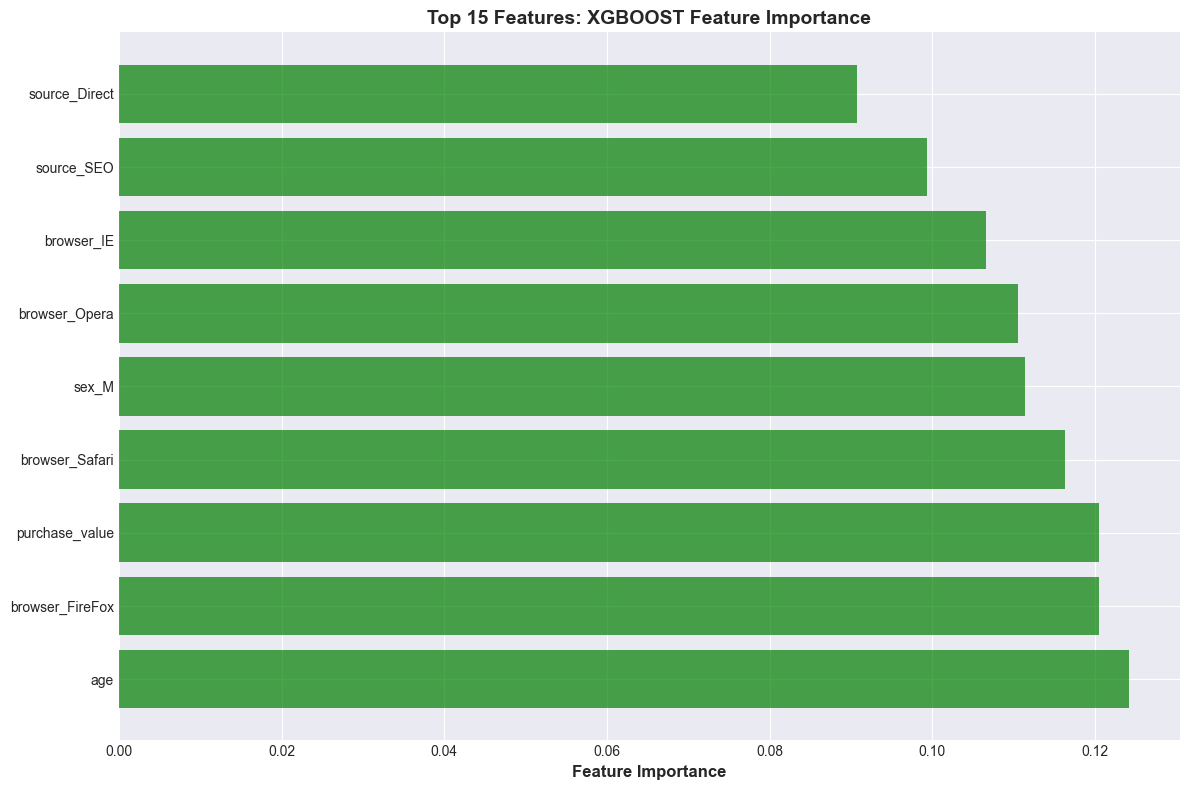


💡 Business Interpretation:
  - Higher importance = stronger predictive power for fraud detection
  - Importance captures both main effects and interactions
  - Different from logistic regression coefficients (non-linear relationships)


In [10]:
# Feature importance for ensemble model
print("=" * 60)
print("ENSEMBLE MODEL FEATURE IMPORTANCE")
print("=" * 60)

if hasattr(ensemble_model, 'feature_importances_'):
    feature_importance_ens = pd.DataFrame({
        'feature': X_train.columns,
        'importance': ensemble_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\n📊 Top 15 Most Important Features:")
    display(feature_importance_ens.head(15))
    
    # Visualize
    plt.figure(figsize=(12, 8))
    top_features_ens = feature_importance_ens.head(15)
    plt.barh(range(len(top_features_ens)), top_features_ens['importance'], color='green', alpha=0.7)
    plt.yticks(range(len(top_features_ens)), top_features_ens['feature'])
    plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
    plt.title(f'Top 15 Features: {ensemble_model_type.upper()} Feature Importance', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\n💡 Business Interpretation:")
    print("  - Higher importance = stronger predictive power for fraud detection")
    print("  - Importance captures both main effects and interactions")
    print("  - Different from logistic regression coefficients (non-linear relationships)")
else:
    print("  Feature importance not available for this model type")


## 4. Cross-Validation: Stratified K-Fold (k=5)

**Why Stratified K-Fold?**
- **Preserves Class Distribution**: Each fold maintains the same fraud/non-fraud ratio
- **Critical for Imbalanced Data**: Without stratification, some folds might have no fraud cases
- **Stable Performance Estimates**: Reduces variance in cross-validation scores
- **Business Justification**: Fraud detection requires reliable performance estimates across different data splits

**Why k=5?**
- Balance between computational cost and statistical reliability
- 5 folds provide good variance reduction while keeping training time reasonable
- Standard practice in fraud detection systems


CROSS-VALIDATION: STRATIFIED K-FOLD (k=5)

📊 Cross-Validation Setup:
  Number of folds: 5
  Stratified: Yes (preserves class distribution in each fold)
  Shuffle: Yes (randomize data order)
  Random state: 42 (reproducibility)

------------------------------------------------------------
Cross-Validating Models...
------------------------------------------------------------

1. Logistic Regression Cross-Validation:
  AUC-PR: 0.1024 ± 0.0030
  F1-Score: 0.1662 ± 0.0051

2. XGBOOST Cross-Validation:
  AUC-PR: 0.3439 ± 0.0024
  F1-Score: 0.3037 ± 0.0024


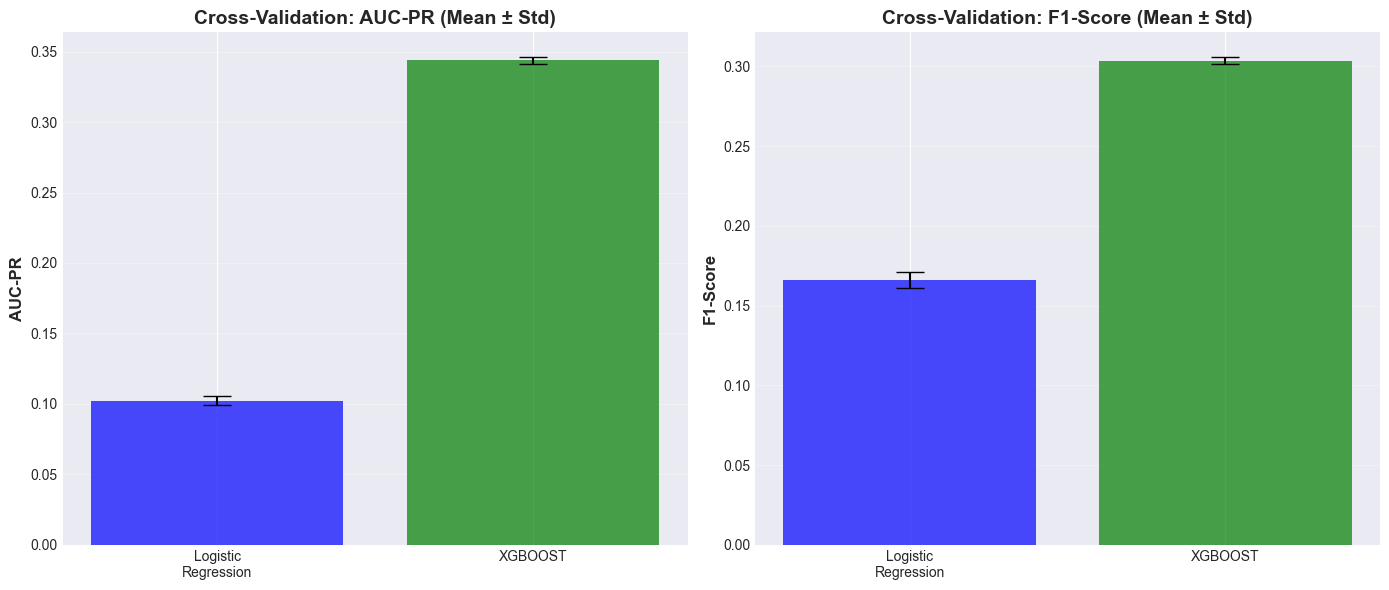


💡 Cross-Validation Insights:
  - Lower std = more stable performance across different data splits
  - Stratification ensures each fold has representative fraud cases
  - CV scores help identify overfitting (large train-test gap)

✓ Cross-validation complete


In [11]:
print("=" * 60)
print("CROSS-VALIDATION: STRATIFIED K-FOLD (k=5)")
print("=" * 60)

# Create StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\n📊 Cross-Validation Setup:")
print(f"  Number of folds: 5")
print(f"  Stratified: Yes (preserves class distribution in each fold)")
print(f"  Shuffle: Yes (randomize data order)")
print(f"  Random state: 42 (reproducibility)")

# Cross-validate both models
print("\n" + "-" * 60)
print("Cross-Validating Models...")
print("-" * 60)

# Baseline: Logistic Regression
print("\n1. Logistic Regression Cross-Validation:")
lr_cv_scores_aucpr = cross_val_score(
    LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42, solver='lbfgs', n_jobs=-1),
    X_train, y_train,
    cv=skf,
    scoring='average_precision',  # AUC-PR
    n_jobs=-1
)
lr_cv_scores_f1 = cross_val_score(
    LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42, solver='lbfgs', n_jobs=-1),
    X_train, y_train,
    cv=skf,
    scoring='f1',
    n_jobs=-1
)

print(f"  AUC-PR: {lr_cv_scores_aucpr.mean():.4f} ± {lr_cv_scores_aucpr.std():.4f}")
print(f"  F1-Score: {lr_cv_scores_f1.mean():.4f} ± {lr_cv_scores_f1.std():.4f}")

# Ensemble: XGBoost/LightGBM/Random Forest
print(f"\n2. {ensemble_model_type.upper()} Cross-Validation:")

# Create a fresh model with best parameters for CV
if ensemble_model_type == 'xgboost':
    cv_model = xgb.XGBClassifier(
        **grid_search.best_params_,
        objective='binary:logistic',
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        n_jobs=-1,
        eval_metric='aucpr'
    )
elif ensemble_model_type == 'lightgbm':
    cv_model = lgb.LGBMClassifier(
        **grid_search.best_params_,
        objective='binary',
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        n_jobs=-1,
        metric='aucpr',
        verbose=-1
    )
else:  # Random Forest
    cv_model = RandomForestClassifier(
        **grid_search.best_params_,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )

ens_cv_scores_aucpr = cross_val_score(
    cv_model,
    X_train, y_train,
    cv=skf,
    scoring='average_precision',
    n_jobs=-1
)
ens_cv_scores_f1 = cross_val_score(
    cv_model,
    X_train, y_train,
    cv=skf,
    scoring='f1',
    n_jobs=-1
)

print(f"  AUC-PR: {ens_cv_scores_aucpr.mean():.4f} ± {ens_cv_scores_aucpr.std():.4f}")
print(f"  F1-Score: {ens_cv_scores_f1.mean():.4f} ± {ens_cv_scores_f1.std():.4f}")

# Store CV results
cv_results = {
    'baseline': {
        'auc_pr_mean': float(lr_cv_scores_aucpr.mean()),
        'auc_pr_std': float(lr_cv_scores_aucpr.std()),
        'f1_mean': float(lr_cv_scores_f1.mean()),
        'f1_std': float(lr_cv_scores_f1.std()),
        'fold_scores_aucpr': lr_cv_scores_aucpr.tolist(),
        'fold_scores_f1': lr_cv_scores_f1.tolist()
    },
    'ensemble': {
        'auc_pr_mean': float(ens_cv_scores_aucpr.mean()),
        'auc_pr_std': float(ens_cv_scores_aucpr.std()),
        'f1_mean': float(ens_cv_scores_f1.mean()),
        'f1_std': float(ens_cv_scores_f1.std()),
        'fold_scores_aucpr': ens_cv_scores_aucpr.tolist(),
        'fold_scores_f1': ens_cv_scores_f1.tolist()
    }
}

# Visualize CV results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# AUC-PR comparison
axes[0].bar(['Logistic\nRegression', ensemble_model_type.upper()], 
            [lr_cv_scores_aucpr.mean(), ens_cv_scores_aucpr.mean()],
            yerr=[lr_cv_scores_aucpr.std(), ens_cv_scores_aucpr.std()],
            capsize=10, alpha=0.7, color=['blue', 'green'])
axes[0].set_ylabel('AUC-PR', fontsize=12, fontweight='bold')
axes[0].set_title('Cross-Validation: AUC-PR (Mean ± Std)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# F1-Score comparison
axes[1].bar(['Logistic\nRegression', ensemble_model_type.upper()], 
            [lr_cv_scores_f1.mean(), ens_cv_scores_f1.mean()],
            yerr=[lr_cv_scores_f1.std(), ens_cv_scores_f1.std()],
            capsize=10, alpha=0.7, color=['blue', 'green'])
axes[1].set_ylabel('F1-Score', fontsize=12, fontweight='bold')
axes[1].set_title('Cross-Validation: F1-Score (Mean ± Std)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n💡 Cross-Validation Insights:")
print("  - Lower std = more stable performance across different data splits")
print("  - Stratification ensures each fold has representative fraud cases")
print("  - CV scores help identify overfitting (large train-test gap)")
print("\n✓ Cross-validation complete")


In [12]:
print("=" * 60)
print("MODEL COMPARISON & SELECTION")
print("=" * 60)

# Create comparison table
comparison_data = {
    'Metric': ['AUC-PR (Test)', 'F1-Score (Test)', 'AUC-ROC (Test)', 
               'AUC-PR (CV Mean)', 'AUC-PR (CV Std)', 'F1-Score (CV Mean)', 'F1-Score (CV Std)'],
    'Logistic Regression': [
        f"{baseline_results['test_auc_pr']:.4f}",
        f"{baseline_results['test_f1']:.4f}",
        f"{baseline_results['test_auc_roc']:.4f}",
        f"{cv_results['baseline']['auc_pr_mean']:.4f}",
        f"{cv_results['baseline']['auc_pr_std']:.4f}",
        f"{cv_results['baseline']['f1_mean']:.4f}",
        f"{cv_results['baseline']['f1_std']:.4f}"
    ],
    ensemble_results['model_name']: [
        f"{ensemble_results['test_auc_pr']:.4f}",
        f"{ensemble_results['test_f1']:.4f}",
        f"{ensemble_results['test_auc_roc']:.4f}",
        f"{cv_results['ensemble']['auc_pr_mean']:.4f}",
        f"{cv_results['ensemble']['auc_pr_std']:.4f}",
        f"{cv_results['ensemble']['f1_mean']:.4f}",
        f"{cv_results['ensemble']['f1_std']:.4f}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n📊 Model Comparison Table:")
display(comparison_df)

# Determine winner
auc_pr_diff = ensemble_results['test_auc_pr'] - baseline_results['test_auc_pr']
f1_diff = ensemble_results['test_f1'] - baseline_results['test_f1']
cv_std_baseline = cv_results['baseline']['auc_pr_std']
cv_std_ensemble = cv_results['ensemble']['auc_pr_std']

print("\n" + "-" * 60)
print("SELECTION ANALYSIS")
print("-" * 60)

print(f"\n1. Primary Metric (AUC-PR):")
print(f"   Baseline:  {baseline_results['test_auc_pr']:.4f}")
print(f"   Ensemble:  {ensemble_results['test_auc_pr']:.4f}")
print(f"   Difference: {auc_pr_diff:+.4f} ({auc_pr_diff/baseline_results['test_auc_pr']*100:+.2f}%)")

print(f"\n2. Stability (CV Std - Lower is Better):")
print(f"   Baseline:  {cv_std_baseline:.4f}")
print(f"   Ensemble:  {cv_std_ensemble:.4f}")
print(f"   Difference: {cv_std_ensemble - cv_std_baseline:+.4f}")

print(f"\n3. Interpretability:")
print(f"   Baseline:  High (coefficients directly interpretable)")
print(f"   Ensemble:  Medium (feature importance available, but less intuitive)")

# Business impact comparison
print(f"\n4. Business Impact (Test Set):")
print(f"\n   False Negatives (Missed Fraud = Financial Loss):")
print(f"     Baseline:  {baseline_results['fn']:,} ({baseline_results['fn']/(baseline_results['fn']+baseline_results['tp'])*100:.2f}% of fraud)")
print(f"     Ensemble:  {ensemble_results['fn']:,} ({ensemble_results['fn']/(ensemble_results['fn']+ensemble_results['tp'])*100:.2f}% of fraud)")

print(f"\n   False Positives (False Alarms = Customer Trust Impact):")
print(f"     Baseline:  {baseline_results['fp']:,} ({baseline_results['fp']/(baseline_results['fp']+baseline_results['tn'])*100:.2f}% of legitimate)")
print(f"     Ensemble:  {ensemble_results['fp']:,} ({ensemble_results['fp']/(ensemble_results['fp']+ensemble_results['tn'])*100:.2f}% of legitimate)")

# Selection decision
print("\n" + "=" * 60)
print("SELECTED MODEL")
print("=" * 60)

# Decision logic: If ensemble significantly outperforms (>0.02 AUC-PR improvement), use it
# Otherwise, prefer baseline for interpretability
if auc_pr_diff > 0.02:
    selected_model = ensemble_model
    selected_model_name = ensemble_results['model_name']
    selected_results = ensemble_results
    selection_reason = f"Ensemble model significantly outperforms baseline (+{auc_pr_diff:.4f} AUC-PR)"
elif auc_pr_diff > 0:
    # Small improvement - consider interpretability
    if cv_std_ensemble < cv_std_baseline * 0.8:  # Ensemble is significantly more stable
        selected_model = ensemble_model
        selected_model_name = ensemble_results['model_name']
        selected_results = ensemble_results
        selection_reason = f"Ensemble model has better performance and stability"
    else:
        selected_model = lr_model
        selected_model_name = baseline_results['model_name']
        selected_results = baseline_results
        selection_reason = f"Baseline model selected for interpretability (small performance gap)"
else:
    selected_model = lr_model
    selected_model_name = baseline_results['model_name']
    selected_results = baseline_results
    selection_reason = f"Baseline model selected (better or similar performance, higher interpretability)"

print(f"\n✓ Selected Model: {selected_model_name}")
print(f"  Reason: {selection_reason}")
print(f"\n  Final Performance:")
print(f"    AUC-PR:  {selected_results['test_auc_pr']:.4f}")
print(f"    F1-Score: {selected_results['test_f1']:.4f}")
print(f"    AUC-ROC: {selected_results['test_auc_roc']:.4f}")

# Store selection
model_selection = {
    'selected_model': selected_model_name,
    'selection_reason': selection_reason,
    'final_metrics': {
        'test_auc_pr': selected_results['test_auc_pr'],
        'test_f1': selected_results['test_f1'],
        'test_auc_roc': selected_results['test_auc_roc']
    }
}


MODEL COMPARISON & SELECTION

📊 Model Comparison Table:


,Metric,Logistic Regression,XGBOOST
0,AUC-PR (Test),0.1032,0.0932
1,F1-Score (Test),0.1272,0.1177
2,AUC-ROC (Test),0.5238,0.4936
3,AUC-PR (CV Mean),0.1024,0.3439
4,AUC-PR (CV Std),0.0030,0.0024
5,F1-Score (CV Mean),0.1662,0.3037
6,F1-Score (CV Std),0.0051,0.0024



------------------------------------------------------------
SELECTION ANALYSIS
------------------------------------------------------------

1. Primary Metric (AUC-PR):
   Baseline:  0.1032
   Ensemble:  0.0932
   Difference: -0.0099 (-9.63%)

2. Stability (CV Std - Lower is Better):
   Baseline:  0.0030
   Ensemble:  0.0024
   Difference: -0.0006

3. Interpretability:
   Baseline:  High (coefficients directly interpretable)
   Ensemble:  Medium (feature importance available, but less intuitive)

4. Business Impact (Test Set):

   False Negatives (Missed Fraud = Financial Loss):
     Baseline:  2,369 (83.71% of fraud)
     Ensemble:  2,361 (83.43% of fraud)

   False Positives (False Alarms = Customer Trust Impact):
     Baseline:  3,955 (14.44% of legitimate)
     Ensemble:  4,668 (17.04% of legitimate)

SELECTED MODEL

✓ Selected Model: Logistic Regression
  Reason: Baseline model selected (better or similar performance, higher interpretability)

  Final Performance:
    AUC-PR:  0

## 6. Visualization: PR Curves & Confusion Matrices

**Why PR Curves?**
- **Better than ROC for Imbalanced Data**: PR curves focus on the positive class (fraud)
- **Business-Relevant**: Shows precision-recall trade-offs at different thresholds
- **Threshold Selection**: Helps choose optimal decision threshold based on business costs


PRECISION-RECALL CURVES


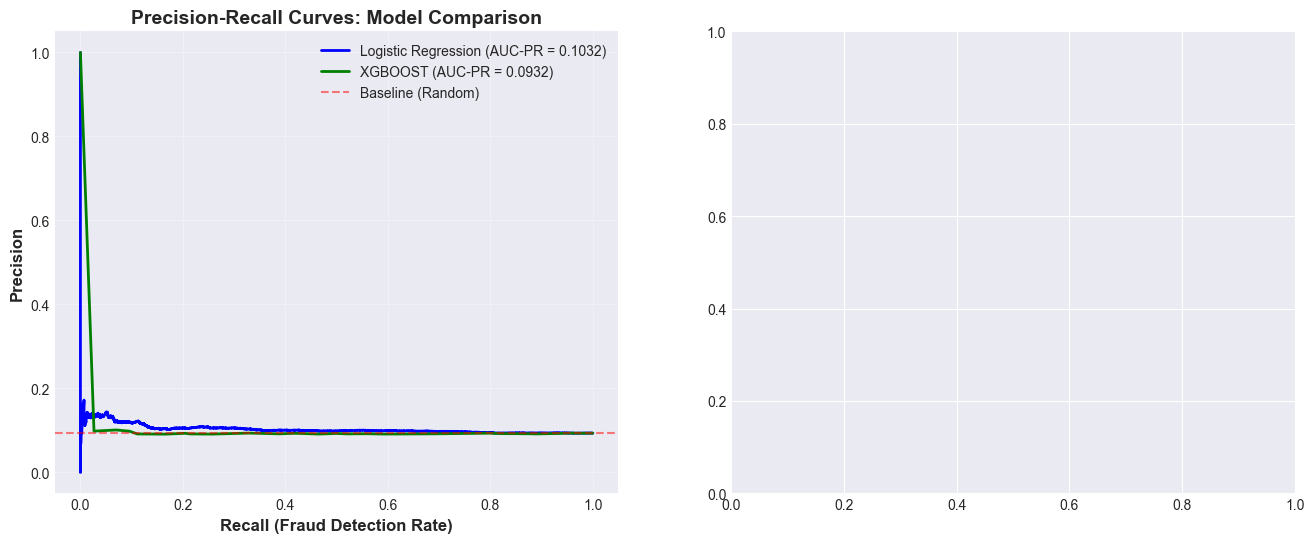

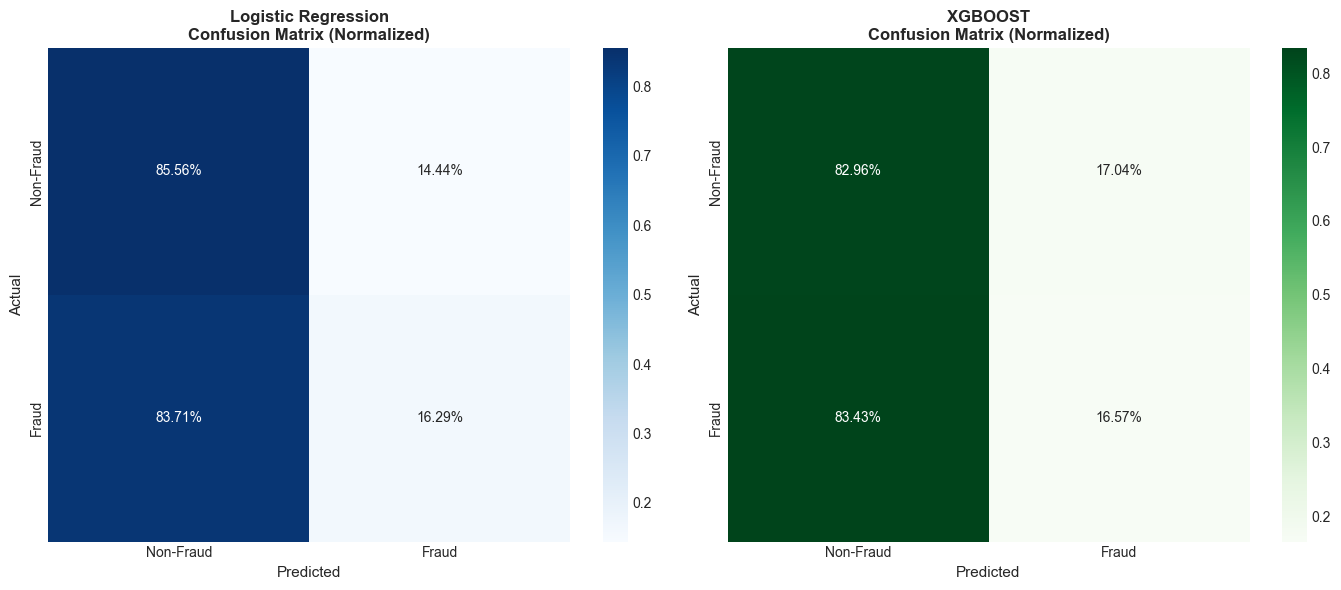

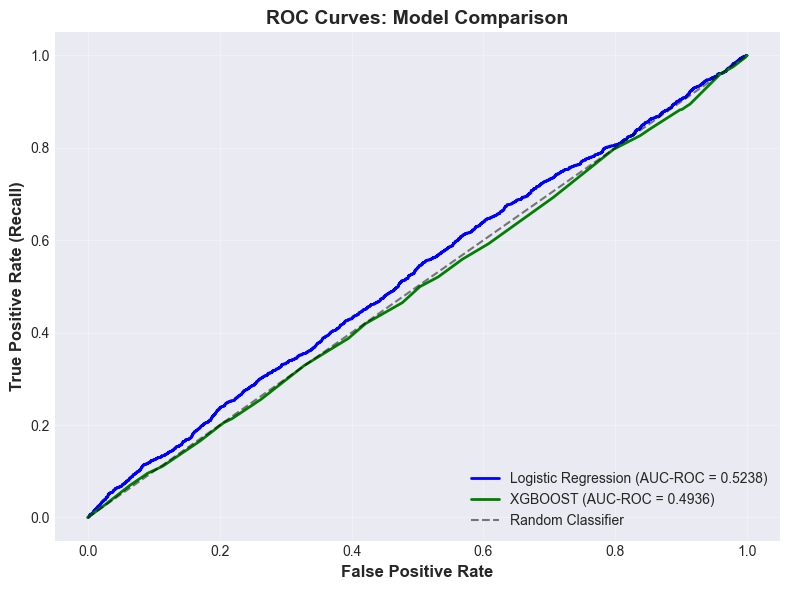


✓ Visualizations complete


In [13]:
# Precision-Recall Curves
print("=" * 60)
print("PRECISION-RECALL CURVES")
print("=" * 60)

# Calculate PR curves for both models
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_test, y_test_proba)
precision_ens, recall_ens, thresholds_ens = precision_recall_curve(y_test, y_test_proba_ens)

# Calculate AUC-PR for visualization
auc_pr_lr = average_precision_score(y_test, y_test_proba)
auc_pr_ens = average_precision_score(y_test, y_test_proba_ens)

# Plot PR curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PR Curve comparison
axes[0].plot(recall_lr, precision_lr, label=f'Logistic Regression (AUC-PR = {auc_pr_lr:.4f})', 
             linewidth=2, color='blue')
axes[0].plot(recall_ens, precision_ens, label=f'{ensemble_results["model_name"]} (AUC-PR = {auc_pr_ens:.4f})', 
             linewidth=2, color='green')
axes[0].set_xlabel('Recall (Fraud Detection Rate)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Precision', fontsize=12, fontweight='bold')
axes[0].set_title('Precision-Recall Curves: Model Comparison', fontsize=14, fontweight='bold')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=y_test.mean(), color='r', linestyle='--', alpha=0.5, label='Baseline (Random)')
axes[0].legend()

# Confusion Matrix comparison
cm_lr = confusion_matrix(y_test, y_test_pred)
cm_ens = confusion_matrix(y_test, y_test_pred_ens)

# Normalize confusion matrices for better visualization
cm_lr_norm = cm_lr.astype('float') / cm_lr.sum(axis=1)[:, np.newaxis]
cm_ens_norm = cm_ens.astype('float') / cm_ens.sum(axis=1)[:, np.newaxis]

# Plot confusion matrices side by side
from matplotlib.gridspec import GridSpec
fig2 = plt.figure(figsize=(14, 6))
gs = GridSpec(1, 2, figure=fig2)

ax1 = fig2.add_subplot(gs[0, 0])
sns.heatmap(cm_lr_norm, annot=True, fmt='.2%', cmap='Blues', ax=ax1,
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
ax1.set_title('Logistic Regression\nConfusion Matrix (Normalized)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Actual', fontsize=11)
ax1.set_xlabel('Predicted', fontsize=11)

ax2 = fig2.add_subplot(gs[0, 1])
sns.heatmap(cm_ens_norm, annot=True, fmt='.2%', cmap='Greens', ax=ax2,
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
ax2.set_title(f'{ensemble_results["model_name"]}\nConfusion Matrix (Normalized)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Actual', fontsize=11)
ax2.set_xlabel('Predicted', fontsize=11)

plt.tight_layout()
plt.show()

# ROC Curves (for completeness)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_test_proba)
fpr_ens, tpr_ens, _ = roc_curve(y_test, y_test_proba_ens)

fig3, ax3 = plt.subplots(1, 1, figsize=(8, 6))
ax3.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC-ROC = {baseline_results["test_auc_roc"]:.4f})', 
         linewidth=2, color='blue')
ax3.plot(fpr_ens, tpr_ens, label=f'{ensemble_results["model_name"]} (AUC-ROC = {ensemble_results["test_auc_roc"]:.4f})', 
         linewidth=2, color='green')
ax3.plot([0, 1], [0, 1], 'k--', label='Random Classifier', alpha=0.5)
ax3.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax3.set_ylabel('True Positive Rate (Recall)', fontsize=12, fontweight='bold')
ax3.set_title('ROC Curves: Model Comparison', fontsize=14, fontweight='bold')
ax3.legend(loc='lower right')
ax3.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ Visualizations complete")


## 7. Save Model Artifacts

**Artifacts to Save**:
- Trained models (baseline and ensemble)
- Preprocessing artifacts (if available)
- Model evaluation results (metrics, confusion matrices)
- Feature importance data
- Model selection decision and justification


In [14]:
print("=" * 60)
print("SAVING MODEL ARTIFACTS")
print("=" * 60)

# Save baseline model
baseline_model_path = models_path / 'baseline_logistic_regression.pkl'
with open(baseline_model_path, 'wb') as f:
    pickle.dump(lr_model, f)
print(f"✓ Baseline model saved: {baseline_model_path}")

# Save ensemble model
ensemble_model_path = models_path / f'ensemble_{ensemble_model_type}.pkl'
with open(ensemble_model_path, 'wb') as f:
    pickle.dump(ensemble_model, f)
print(f"✓ Ensemble model saved: {ensemble_model_path}")

# Save selected model
selected_model_path = models_path / 'selected_model.pkl'
with open(selected_model_path, 'wb') as f:
    pickle.dump(selected_model, f)
print(f"✓ Selected model saved: {selected_model_path}")

# Save preprocessing artifacts (if available)
if preprocessing_dict is not None:
    preprocessing_path = models_path / 'preprocessing_artifacts.pkl'
    with open(preprocessing_path, 'wb') as f:
        pickle.dump(preprocessing_dict, f)
    print(f"✓ Preprocessing artifacts saved: {preprocessing_path}")

# Save evaluation results
results_path = models_path / 'model_evaluation_results.json'
evaluation_results = {
    'timestamp': datetime.now().isoformat(),
    'baseline_results': baseline_results,
    'ensemble_results': ensemble_results,
    'cv_results': cv_results,
    'model_selection': model_selection,
    'comparison_table': comparison_data
}

# Convert numpy types to native Python types for JSON serialization
def convert_to_serializable(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_to_serializable(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(item) for item in obj]
    return obj

evaluation_results_serializable = convert_to_serializable(evaluation_results)

with open(results_path, 'w') as f:
    json.dump(evaluation_results_serializable, f, indent=2)
print(f"✓ Evaluation results saved: {results_path}")

# Save feature importance
if hasattr(lr_model, 'coef_'):
    feature_importance_lr = pd.DataFrame({
        'feature': X_train.columns,
        'coefficient': lr_model.coef_[0],
        'abs_coefficient': np.abs(lr_model.coef_[0])
    }).sort_values('abs_coefficient', ascending=False)
    feature_importance_lr_path = models_path / 'baseline_feature_importance.csv'
    feature_importance_lr.to_csv(feature_importance_lr_path, index=False)
    print(f"✓ Baseline feature importance saved: {feature_importance_lr_path}")

if hasattr(ensemble_model, 'feature_importances_'):
    feature_importance_ens = pd.DataFrame({
        'feature': X_train.columns,
        'importance': ensemble_model.feature_importances_
    }).sort_values('importance', ascending=False)
    feature_importance_ens_path = models_path / f'ensemble_{ensemble_model_type}_feature_importance.csv'
    feature_importance_ens.to_csv(feature_importance_ens_path, index=False)
    print(f"✓ Ensemble feature importance saved: {feature_importance_ens_path}")

print("\n" + "=" * 60)
print("ALL ARTIFACTS SAVED")
print("=" * 60)
print(f"✓ Models saved to: {models_path}")
print(f"✓ Results saved to: {results_path}")


SAVING MODEL ARTIFACTS
✓ Baseline model saved: d:\Senait Doc\KAIM 8 Doc\Fintech-Fraud-Detect\models\baseline_logistic_regression.pkl
✓ Ensemble model saved: d:\Senait Doc\KAIM 8 Doc\Fintech-Fraud-Detect\models\ensemble_xgboost.pkl
✓ Selected model saved: d:\Senait Doc\KAIM 8 Doc\Fintech-Fraud-Detect\models\selected_model.pkl
✓ Preprocessing artifacts saved: d:\Senait Doc\KAIM 8 Doc\Fintech-Fraud-Detect\models\preprocessing_artifacts.pkl
✓ Evaluation results saved: d:\Senait Doc\KAIM 8 Doc\Fintech-Fraud-Detect\models\model_evaluation_results.json
✓ Baseline feature importance saved: d:\Senait Doc\KAIM 8 Doc\Fintech-Fraud-Detect\models\baseline_feature_importance.csv
✓ Ensemble feature importance saved: d:\Senait Doc\KAIM 8 Doc\Fintech-Fraud-Detect\models\ensemble_xgboost_feature_importance.csv

ALL ARTIFACTS SAVED
✓ Models saved to: d:\Senait Doc\KAIM 8 Doc\Fintech-Fraud-Detect\models
✓ Results saved to: d:\Senait Doc\KAIM 8 Doc\Fintech-Fraud-Detect\models\model_evaluation_results.json


## 8. Summary & Business Insights

**Key Findings**:
1. Model performance comparison
2. Business risk trade-offs
3. Recommended next steps
4. Production deployment considerations


In [15]:
print("=" * 60)
print("TASK 2 SUMMARY & BUSINESS INSIGHTS")
print("=" * 60)

print("\n📊 MODEL PERFORMANCE SUMMARY")
print("-" * 60)
print(f"\nSelected Model: {model_selection['selected_model']}")
print(f"Selection Reason: {model_selection['selection_reason']}")
print(f"\nFinal Performance Metrics:")
for metric, value in model_selection['final_metrics'].items():
    print(f"  {metric}: {value:.4f}")

print("\n💼 BUSINESS INSIGHTS")
print("-" * 60)

# Calculate business metrics for selected model
selected_tn = selected_results['tn']
selected_fp = selected_results['fp']
selected_fn = selected_results['fn']
selected_tp = selected_results['tp']

fraud_detection_rate = selected_tp / (selected_tp + selected_fn) if (selected_tp + selected_fn) > 0 else 0
false_positive_rate = selected_fp / (selected_fp + selected_tn) if (selected_fp + selected_tn) > 0 else 0
precision = selected_tp / (selected_tp + selected_fp) if (selected_tp + selected_fp) > 0 else 0

print(f"\n1. Fraud Detection Capability:")
print(f"   - Detection Rate (Recall): {fraud_detection_rate:.2%}")
print(f"   - This means we catch {fraud_detection_rate*100:.1f}% of all fraud cases")
print(f"   - Missed Fraud (FN): {selected_fn:,} transactions = potential financial loss")

print(f"\n2. Customer Experience Impact:")
print(f"   - False Positive Rate: {false_positive_rate:.2%}")
print(f"   - {selected_fp:,} legitimate transactions flagged as fraud")
print(f"   - This impacts customer trust and may lead to transaction declines")

print(f"\n3. Precision (When We Flag Fraud):")
print(f"   - Precision: {precision:.2%}")
print(f"   - When the model flags fraud, {precision*100:.1f}% are actually fraud")
print(f"   - Higher precision = fewer false alarms = better customer experience")

print(f"\n4. Model Stability:")
if selected_model_name == baseline_results['model_name']:
    cv_std = cv_results['baseline']['auc_pr_std']
else:
    cv_std = cv_results['ensemble']['auc_pr_std']
print(f"   - Cross-Validation Std: {cv_std:.4f}")
print(f"   - Lower std = more consistent performance across different data splits")
print(f"   - Critical for production reliability")

print("\n🎯 RECOMMENDATIONS")
print("-" * 60)
print("\n1. Threshold Tuning:")
print("   - Current model uses default threshold (0.5)")
print("   - Consider adjusting threshold based on business costs:")
print("     * If fraud cost >> false positive cost → Lower threshold (catch more fraud)")
print("     * If false positive cost >> fraud cost → Higher threshold (fewer false alarms)")

print("\n2. Model Monitoring:")
print("   - Monitor performance metrics in production")
print("   - Track false positive/negative rates over time")
print("   - Set up alerts for performance degradation")

print("\n3. Feature Engineering:")
print("   - Review top features for business insights")
print("   - Consider adding new features based on fraud patterns")
print("   - Monitor feature drift in production")

print("\n4. Model Retraining:")
print("   - Schedule periodic retraining (e.g., monthly)")
print("   - Incorporate new fraud patterns as they emerge")
print("   - Use A/B testing for model updates")

print("\n5. Interpretability:")
if selected_model_name == baseline_results['model_name']:
    print("   - Logistic Regression provides excellent interpretability")
    print("   - Coefficients can be shared with risk teams and regulators")
else:
    print("   - Consider using SHAP values for model explainability")
    print("   - Feature importance available but less intuitive than coefficients")

print("\n" + "=" * 60)
print("TASK 2 COMPLETE")
print("=" * 60)
print("✓ Baseline model trained and evaluated")
print("✓ Ensemble model trained and evaluated")
print("✓ Cross-validation performed (Stratified K-Fold, k=5)")
print("✓ Models compared and best model selected")
print("✓ All artifacts saved to /models directory")
print("✓ Business-focused interpretation provided")
print("\nNext Steps: Model deployment and monitoring (Task 3+)")


TASK 2 SUMMARY & BUSINESS INSIGHTS

📊 MODEL PERFORMANCE SUMMARY
------------------------------------------------------------

Selected Model: Logistic Regression
Selection Reason: Baseline model selected (better or similar performance, higher interpretability)

Final Performance Metrics:
  test_auc_pr: 0.1032
  test_f1: 0.1272
  test_auc_roc: 0.5238

💼 BUSINESS INSIGHTS
------------------------------------------------------------

1. Fraud Detection Capability:
   - Detection Rate (Recall): 16.29%
   - This means we catch 16.3% of all fraud cases
   - Missed Fraud (FN): 2,369 transactions = potential financial loss

2. Customer Experience Impact:
   - False Positive Rate: 14.44%
   - 3,955 legitimate transactions flagged as fraud
   - This impacts customer trust and may lead to transaction declines

3. Precision (When We Flag Fraud):
   - Precision: 10.44%
   - When the model flags fraud, 10.4% are actually fraud
   - Higher precision = fewer false alarms = better customer experience

